In [2]:
# Import libraries
import pandas as pd
import numpy  as np
import os
import matplotlib.pyplot as plt
from scipy import stats

from sklearn import decomposition
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import time
from tensorflow import keras
import tensorflow as tf
from keras.metrics import SparseCategoricalAccuracy
from keras.metrics import Recall
from sklearn.metrics import confusion_matrix
from keras import backend as K
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import load_model
import keras_tuner as kt

# from numpy.random import seed
# seed(1)
# tf.random.set_seed(2)

## Pre-processing data

In [3]:
# Read sensor data with labels

hr_original = pd.read_csv("../feature_extraction/heart_rate_features_all_pid.csv")
acc_original = pd.read_csv("../feature_extraction/accelerometer_features_all_pid.csv")

sensor_merge = hr_original.merge(acc_original, on=["timestamp", "pid"], suffixes=("_hr","_acc"))

# Create dataframe with arousal and valence
sensor_merge_arousal = sensor_merge.drop(columns=(["valence_bin_hr","arousal_hr","valence_hr", "arousal_bin_acc", "count_hr", "valence_bin_acc","arousal_acc","valence_acc", "count_acc"]))
sensor_merge_valence = sensor_merge.drop(columns=(["arousal_bin_hr","arousal_hr","valence_hr", "valence_bin_acc", "count_hr", "arousal_bin_acc","arousal_acc","valence_acc", "count_acc"]))

# Rename arousal
sensor_merge_arousal.rename(columns = {'arousal_bin_hr':'Arousal_binary'}, inplace = True)
sensor_merge_valence.rename(columns = {'valence_bin_hr':'Valence_binary'}, inplace = True)


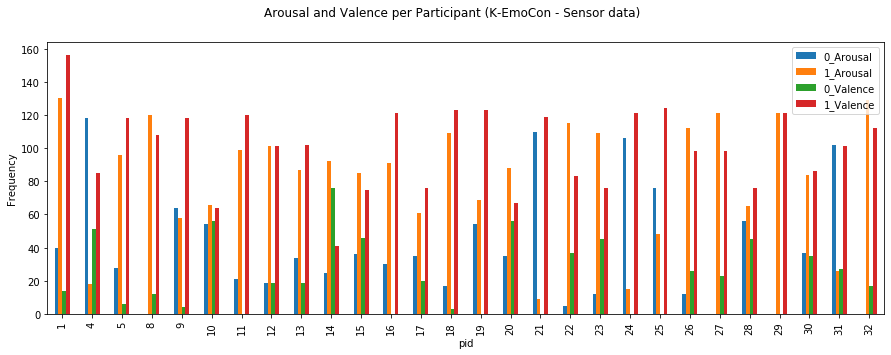

<Figure size 432x288 with 0 Axes>

In [4]:
# Removing participants with 100% imbalance

arousal_df = sensor_merge_arousal.groupby("pid")['Arousal_binary'].value_counts().unstack()
valence_df = sensor_merge_valence.groupby("pid")['Valence_binary'].value_counts().unstack()

merged_counts = arousal_df.merge(valence_df, on='pid',suffixes=('_Arousal', '_Valence')).fillna(0)

merged_counts.plot.bar(figsize=(15,5))
plt.suptitle("Arousal and Valence per Participant (K-EmoCon - Sensor data)")
plt.ylabel("Frequency")
plt.show()
plt.savefig("KEmoCon_AV_per_participant.png")

In [5]:
# Removing participants with 100% imbalance in arousal

list_of_remove_participants_arousal = [8,27,29,32]
for pid in list_of_remove_participants_arousal:
    sensor_merge_arousal = sensor_merge_arousal[sensor_merge_arousal.pid != pid]
    
# Define groups
sensor_merge_arousal_groups = sensor_merge_arousal['pid']

In [6]:
# Removing participants with 100% imbalance in valence

list_of_remove_participants_valence = [11,16,19,21,24,25,29]
for pid in list_of_remove_participants_valence:
    sensor_merge_valence = sensor_merge_valence[sensor_merge_valence.pid != pid]
    
# Define groups
sensor_merge_valence_groups = sensor_merge_valence['pid']

In [7]:
# Shapes to check if merge done properly and samples left after removing participants in each emotion dimension

print(hr_original.shape)
print(acc_original.shape)
print(sensor_merge.shape)
print()
print(sensor_merge_arousal.shape)
print(sensor_merge_valence.shape)

(3450, 17)
(3451, 17)
(3450, 32)

(2959, 23)
(2601, 23)


## Applying ML and DNN

In [8]:
# Splitting in X and y and validation

smA_x_all = sensor_merge_arousal.drop(columns=(["timestamp","Arousal_binary","pid"]))
smA_y_all = sensor_merge_arousal["Arousal_binary"]

# Get stratified split to make validation set
cv = StratifiedGroupKFold(n_splits=8, random_state=4, shuffle=True)
for folds, (train_idxs, test_idxs) in enumerate(cv.split(smA_x_all, smA_y_all, sensor_merge_arousal_groups)):
    if folds == 1: 
        smA_x = smA_x_all.iloc[train_idxs]
        smA_y = smA_y_all.iloc[train_idxs]
        smA_x_val = smA_x_all.iloc[test_idxs]
        smA_y_val = smA_y_all.iloc[test_idxs]

        train_test_groups_arousal = sensor_merge_arousal_groups.iloc[train_idxs]
        val_groups_arousal = sensor_merge_arousal_groups.iloc[test_idxs]

        train_test_groups_arousal_unique = np.unique(sensor_merge_arousal_groups.iloc[train_idxs])
        val_groups_arousal_unique = np.unique(sensor_merge_arousal_groups.iloc[test_idxs])
        
print(smA_x.shape)
print(smA_x_val.shape)
print("Train test groups: ", train_test_groups_arousal_unique)
print("Validation groups: ", val_groups_arousal_unique)

(2592, 20)
(367, 20)
Train test groups:  [ 1  4  5  9 10 11 13 14 15 16 17 19 20 21 22 24 25 26 28 30 31]
Validation groups:  [12 18 23]


In [149]:
# Hyperparameter tuning SVM

# StratifiedKGroupFold
sgkf = StratifiedGroupKFold(n_splits=6, random_state=10, shuffle=True)
svm = SVC()

# Grid search
space = dict()
space['degree'] = [2,3,4]
space['kernel'] = ['linear', 'poly', 'rbf', 'sigmoid']
space['C'] = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10]
space['class_weight'] = ['balanced',None]
search = GridSearchCV(svm, space, scoring='balanced_accuracy', verbose=4, n_jobs=-1, cv=sgkf)
result = search.fit(smA_x, smA_y, groups=train_test_groups_arousal)

# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)


Fitting 6 folds for each of 192 candidates, totalling 1152 fits
Best Score: 0.5231898954251143
Best Hyperparameters: {'C': 1, 'class_weight': None, 'degree': 2, 'kernel': 'sigmoid'}


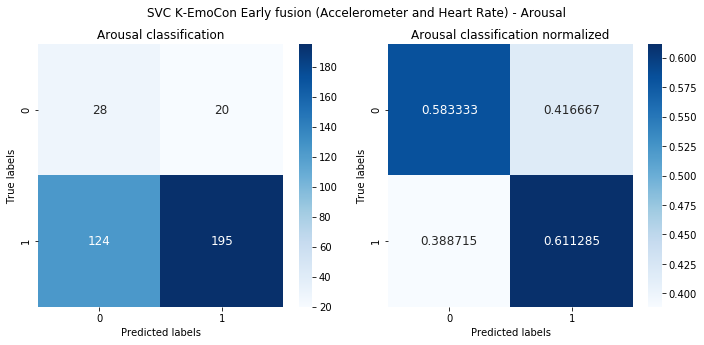

SVM validation Arousal score with best hyperparameters: 0.5973092998955067


In [9]:
# Using the hyperparameters on validation set
# Change X_train variable names to avoid confusion later

X_train = smA_x
y_train = smA_y
X_test = smA_x_val
y_test = smA_y_val

# StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fitting SVM training
svm = SVC(C=1,class_weight=None, degree=2, kernel="sigmoid")
svm.fit(X_train_scaled, y_train),
y_pred = svm.predict(X_test_scaled)

uar = balanced_accuracy_score(y_test,y_pred)

# Plotting the confusion matrix
cm = confusion_matrix(y_test,y_pred)
cm_normalized = confusion_matrix(y_test,y_pred, normalize="true")
fig, axs = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('SVC K-EmoCon Early fusion (Accelerometer and Heart Rate) - Arousal')
sns.heatmap(cm, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[0]) 
sns.heatmap(cm_normalized, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[1]) 
axs[0].set_title('Arousal classification')
axs[1].set_title('Arousal classification normalized')
for ax in axs.flat:
    ax.set(xlabel='Predicted labels', ylabel='True labels')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("SVM validation Arousal score with best hyperparameters:", uar)

In [10]:
# Creating a train and test set for hyperparameter tuning

cv = StratifiedGroupKFold(n_splits=8, random_state=9, shuffle=True)
for folds, (train_idxs, test_idxs) in enumerate(cv.split(smA_x, smA_y, train_test_groups_arousal)):
    if folds == 1: 
        smA_x_train = smA_x_all.iloc[train_idxs]
        smA_y_train = smA_y_all.iloc[train_idxs]
        smA_x_test = smA_x_all.iloc[test_idxs]
        smA_y_test = smA_y_all.iloc[test_idxs]
        
        smA_x_train_groups = np.unique(train_test_groups_arousal.iloc[train_idxs])
        smA_x_test_groups = np.unique(train_test_groups_arousal.iloc[test_idxs])
        
print("Training groups: ", smA_x_train_groups)
print("Testing groups: ", smA_x_test_groups)

# StandardScaler
scaler = StandardScaler()
smA_x_train = scaler.fit_transform(smA_x_train)
smA_x_test = scaler.transform(smA_x_test)

Training groups:  [ 4  5  9 10 11 13 14 15 16 17 19 20 21 22 24 25 26 31]
Testing groups:  [ 1 28 30]


In [11]:
def UAR_metric(y_true, y_pred):
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)))
    uar = ((tp / (tp+fn+K.epsilon())) + (tn /(tn+fp+K.epsilon()))) /2
    return uar

In [165]:
# Hyperparameter tuning

def model_builder(hp):
    model = keras.Sequential()
    hp_units = hp.Int('units', min_value=16, max_value=512, step=16)
    model.add(Dense(hp_units, input_dim=20, activation="relu"))
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    
    dp1 = hp.Choice('dp1', values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
    model.add(Dropout(dp1))
    
    hp_units1 = hp.Int('units1', min_value=16, max_value=512, step=16)
    model.add(Dense(units=hp_units, activation='relu'))
    # Tune the number of units in the first Dense layer
    
    dp2 = hp.Choice('dp2', values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
    model.add(Dropout(dp2))
    
    hp_units2 = hp.Int('units2', min_value=16, max_value=512, step=16)
    model.add(Dense(units=hp_units2, activation='relu'))
    
    dp3 = hp.Choice('dp3', values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
    model.add(Dropout(dp3))
    
    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss="binary_crossentropy",
                metrics=[UAR_metric])
    return model

# Initialize the hyperparameter tuner

tuner = kt.Hyperband(model_builder,objective=kt.Objective('val_UAR_metric', direction='max'),
                     max_epochs=100,
                     factor=10,
                     directory='KEmoCon_SensorMerge',
                     project_name='Trial8Arousal')

# Stop early if validation doesn't change for 10 epochs
stop_early = keras.callbacks.EarlyStopping(monitor='val_UAR_metric', patience=10)
tuner.search(smA_x_train, smA_y_train, epochs=100, validation_data=(smA_x_test, smA_y_test), callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. \n First layer: {best_hps.get('units')} \n Second layer: {best_hps.get('units1')} \n Third layer: {best_hps.get('units2')} \n \n Dropout 1: {best_hps.get('dp1')} \n Dropout 2: {best_hps.get('dp2')} \n Dropout 3: {best_hps.get('dp3')} \n and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

INFO:tensorflow:Reloading Oracle from existing project KEmoCon_SensorMerge\Trial8Arousal\oracle.json
INFO:tensorflow:Reloading Tuner from KEmoCon_SensorMerge\Trial8Arousal\tuner0.json
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. 
 First layer: 32 
 Second layer: 448 
 Third layer: 256 
 
 Dropout 1: 0.4 
 Dropout 2: 0.4 
 Dropout 3: 0.3 
 and the optimal learning rate for the optimizer
is 1e-05.



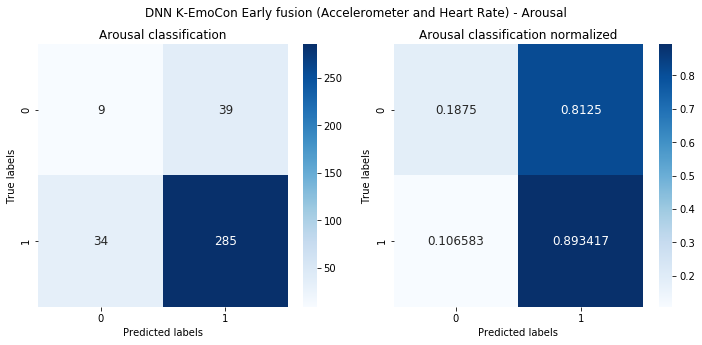

K-EmoCon DNN Early Fusion with best hyperparameters -- Arousal 0.5404584639498433


In [61]:
# Using the hyperparameters on validation set
# Change X_train variable names to avoid confusion later

X_train = smA_x
y_train = smA_y
X_test = smA_x_val
y_test = smA_y_val

# StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fitting DNN
sensor_merge_model_arousal = Sequential()
sensor_merge_model_arousal.add(Dense(32, input_dim=20, activation="relu"))
sensor_merge_model_arousal.add(Dropout(0.4))
sensor_merge_model_arousal.add(Dense(448, activation="relu"))
sensor_merge_model_arousal.add(Dropout(0.4))
sensor_merge_model_arousal.add(Dense(256, activation="relu"))
sensor_merge_model_arousal.add(Dropout(0.3))
sensor_merge_model_arousal.add(Dense(1, activation="sigmoid"))
opt = keras.optimizers.Adam(learning_rate=1e-05)
sensor_merge_model_arousal.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
sensor_merge_model_arousal.fit(X_train_scaled, y_train, epochs = 100, verbose=0)

# Prediction
y_pred = sensor_merge_model_arousal.predict(X_test_scaled, verbose=0)
y_pred = np.rint(y_pred)
uar = balanced_accuracy_score(y_test, y_pred)

# Plotting the confusion matrix
cm = confusion_matrix(y_test,y_pred)
cm_normalized = confusion_matrix(y_test,y_pred, normalize="true")
fig, axs = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('DNN K-EmoCon Early fusion (Accelerometer and Heart Rate) - Arousal')
sns.heatmap(cm, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[0]) 
sns.heatmap(cm_normalized, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[1]) 
axs[0].set_title('Arousal classification')
axs[1].set_title('Arousal classification normalized')
for ax in axs.flat:
    ax.set(xlabel='Predicted labels', ylabel='True labels')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
print("K-EmoCon DNN Early Fusion with best hyperparameters -- Arousal", uar)

In [122]:
## Saving model for transfer learning

sensor_merge_model_arousal.save('KEmoCon_sensor_earlyfusion_arousal.h5')

## Early fusion: Valence

In [22]:
# Splitting in X and y and validation

smV_x_all = sensor_merge_valence.drop(columns=(["timestamp","Valence_binary","pid"]))
smV_y_all = sensor_merge_valence["Valence_binary"]

# Get stratified split to make validation set
cv = StratifiedGroupKFold(n_splits=8, random_state=4, shuffle=True)
for folds, (train_idxs, test_idxs) in enumerate(cv.split(smV_x_all, smV_y_all, sensor_merge_valence_groups)):
    if folds == 1: 
        smV_x = smV_x_all.iloc[train_idxs]
        smV_y = smV_y_all.iloc[train_idxs]
        smV_x_val = smV_x_all.iloc[test_idxs]
        smV_y_val = smV_y_all.iloc[test_idxs]

        train_test_groups_valence = sensor_merge_valence_groups.iloc[train_idxs]
        val_groups_valence = sensor_merge_valence_groups.iloc[test_idxs]

        train_test_groups_valence_unique = np.unique(sensor_merge_valence_groups.iloc[train_idxs])
        val_groups_valence_unique = np.unique(sensor_merge_valence_groups.iloc[test_idxs])
        
print(smV_x.shape)
print(smV_x_val.shape)
print("Train test groups: ", train_test_groups_valence_unique)
print("Validation groups: ", val_groups_valence_unique)

(2214, 20)
(387, 20)
Train test groups:  [ 4  5  8  9 10 12 13 14 15 18 20 22 26 27 28 30 31 32]
Validation groups:  [ 1 17 23]


In [61]:
# Hyperparameter tuning

start_time = time.time()
# StratifiedKGroupFold
sgkf = StratifiedGroupKFold(n_splits=10, random_state=10, shuffle=True)
svm = SVC()

# Grid search
space = dict()
space['degree'] = [2,3,4]
space['kernel'] = ['linear', 'poly', 'rbf', 'sigmoid']
space['C'] = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10]
space['class_weight'] = ['balanced',None]
search = GridSearchCV(svm, space, scoring='balanced_accuracy', verbose=4, n_jobs=-1, cv=sgkf)
result = search.fit(smV_x, smV_y, groups=train_test_groups_valence)

# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

end_time = time.time()
print("Time taken: ", end_time - start_time)

Fitting 10 folds for each of 192 candidates, totalling 1920 fits
Best Score: 0.5447655319269054
Best Hyperparameters: {'C': 0.1, 'class_weight': 'balanced', 'degree': 2, 'kernel': 'rbf'}
Time taken:  731.335875749588


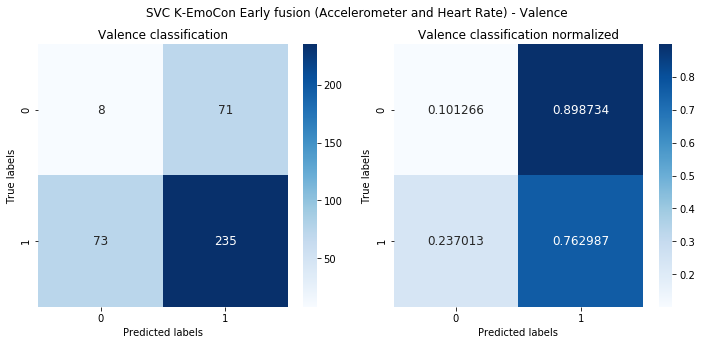

SVM validation score valence with best hyperparameters: 0.43212641788591155


In [23]:
# Using the hyperparameters on validation set
# Change X_train variable names to avoid confusion later

X_train = smV_x
y_train = smV_y
X_test = smV_x_val
y_test = smV_y_val

# StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fitting SVM training
svm = SVC(C=0.1,class_weight="balanced", degree=2, kernel="rbf")
svm.fit(X_train_scaled, y_train),
y_pred = svm.predict(X_test_scaled)

uar = balanced_accuracy_score(y_test,y_pred)

# Plotting the confusion matrix
cm = confusion_matrix(y_test,y_pred)
cm_normalized = confusion_matrix(y_test,y_pred, normalize="true")
fig, axs = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('SVC K-EmoCon Early fusion (Accelerometer and Heart Rate) - Valence')
sns.heatmap(cm, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[0]) 
sns.heatmap(cm_normalized, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[1]) 
axs[0].set_title('Valence classification')
axs[1].set_title('Valence classification normalized')
for ax in axs.flat:
    ax.set(xlabel='Predicted labels', ylabel='True labels')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("SVM validation score valence with best hyperparameters:", uar)

In [126]:
# Creating a train and test set for hyperparameter tuning

cv = StratifiedGroupKFold(n_splits=5, random_state=12, shuffle=True)
for folds, (train_idxs, test_idxs) in enumerate(cv.split(smV_x, smV_y, train_test_groups_valence)):
    if folds == 1: 
        smV_x_train = smV_x_all.iloc[train_idxs]
        smV_y_train = smV_y_all.iloc[train_idxs]
        smV_x_test = smV_x_all.iloc[test_idxs]
        smV_y_test = smV_y_all.iloc[test_idxs]
        
        smV_x_train_groups = np.unique(train_test_groups_valence.iloc[train_idxs])
        smV_x_test_groups = np.unique(train_test_groups_valence.iloc[test_idxs])
        
print("Training groups: ", smV_x_train_groups)
print("Testing groups: ", smV_x_test_groups)

Training groups:  [ 4  5  8 12 13 14 15 18 20 22 27 28 30 32]
Testing groups:  [ 9 10 26 31]


In [58]:
# Hyperparameter tuning

def model_builder(hp):
    model = keras.Sequential()
    hp_units = hp.Int('units', min_value=16, max_value=512, step=16)
    model.add(Dense(hp_units, input_dim=20, activation="relu"))
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    
    dp1 = hp.Choice('dp1', values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
    model.add(Dropout(dp1))
    
    hp_units1 = hp.Int('units1', min_value=16, max_value=512, step=16)
    model.add(Dense(units=hp_units, activation='relu'))
    # Tune the number of units in the first Dense layer
    
    dp2 = hp.Choice('dp2', values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
    model.add(Dropout(dp2))
    
    hp_units2 = hp.Int('units2', min_value=16, max_value=512, step=16)
    model.add(Dense(units=hp_units2, activation='relu'))
    
    dp3 = hp.Choice('dp3', values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
    model.add(Dropout(dp3))
    
    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss="binary_crossentropy",
                metrics=[UAR_metric])
    return model

# Initialize the hyperparameter tuner

tuner = kt.Hyperband(model_builder,objective=kt.Objective('val_UAR_metric', direction='max'),
                     max_epochs=100,
                     factor=10,
                     directory='KEmoCon_SensorMerge',
                     project_name='Trial4Valence')

# Stop early if validation doesn't change for 10 epochs
stop_early = keras.callbacks.EarlyStopping(monitor='val_UAR_metric', patience=10)
tuner.search(smV_x_train, smV_y_train, epochs=100, validation_data=(smV_x_test, smV_y_test), callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. \n First layer: {best_hps.get('units')} \n Second layer: {best_hps.get('units1')} \n Third layer: {best_hps.get('units2')} \n \n Dropout 1: {best_hps.get('dp1')} \n Dropout 2: {best_hps.get('dp2')} \n Dropout 3: {best_hps.get('dp3')} \n and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 131 Complete [00h 00m 04s]
val_UAR_metric: 0.5

Best val_UAR_metric So Far: 0.5194011926651001
Total elapsed time: 00h 03m 54s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. 
 First layer: 128 
 Second layer: 96 
 Third layer: 64 
 
 Dropout 1: 0.2 
 Dropout 2: 0.4 
 Dropout 3: 0.0 
 and the optimal learning rate for the optimizer
is 0.001.



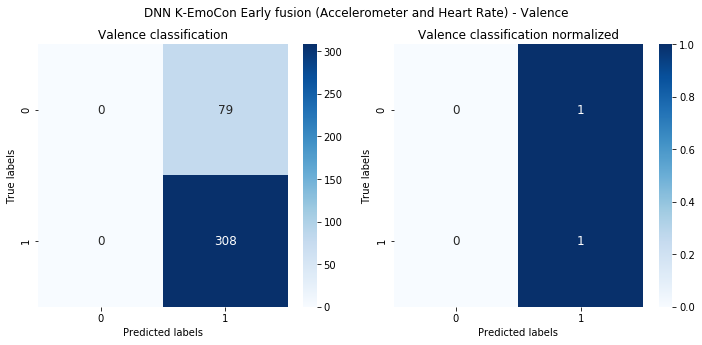

DNN validation score with best hyperparameters for valence: 0.5


In [18]:
# Using the hyperparameters on validation set
# Change X_train variable names to avoid confusion later

X_train = smV_x
y_train = smV_y
X_test = smV_x_val
y_test = smV_y_val

# StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fitting DNN
sensor_merge_model_valence = Sequential()
sensor_merge_model_valence.add(Dense(160, input_dim=20, activation="relu"))
sensor_merge_model_valence.add(Dropout(0.1))
sensor_merge_model_valence.add(Dense(192, activation="relu"))
sensor_merge_model_valence.add(Dropout(0.4))
sensor_merge_model_valence.add(Dense(144, activation="relu"))
sensor_merge_model_valence.add(Dropout(0.0))
sensor_merge_model_valence.add(Dense(1, activation="sigmoid"))
opt = keras.optimizers.Adam(learning_rate=1e-05)
sensor_merge_model_valence.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
# stop_early = keras.callbacks.EarlyStopping(monitor='UAR_metric', patience=10)
sensor_merge_model_valence.fit(X_train_scaled, y_train, epochs = 100, verbose=0)

# Prediction
y_pred = sensor_merge_model_valence.predict(X_test_scaled, verbose=0)
y_pred = np.rint(y_pred)
uar = balanced_accuracy_score(y_test, y_pred)

# Plotting the confusion matrix
cm = confusion_matrix(y_test,y_pred)
cm_normalized = confusion_matrix(y_test,y_pred, normalize="true")
fig, axs = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('DNN K-EmoCon Early fusion (Accelerometer and Heart Rate) - Valence')
sns.heatmap(cm, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[0]) 
sns.heatmap(cm_normalized, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[1]) 
axs[0].set_title('Valence classification')
axs[1].set_title('Valence classification normalized')
for ax in axs.flat:
    ax.set(xlabel='Predicted labels', ylabel='True labels')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("DNN validation score with best hyperparameters for valence:", uar)

In [128]:
## Saving model for transfer learning

sensor_merge_model_valence.save('KEmoCon_sensor_earlyfusion_valence.h5')

## Late fusion pre-processing

In [24]:
# Defining unimodal and groups -- arousal

hr_unimodal_labels_merge_arousal = sensor_merge_arousal[['timestamp', 'mean_hr', 'std_hr', 'min_hr', '25%_hr', '50%_hr','75%_hr', 'max_hr', 'data_range_hr', 'skewness_hr', 'kurtosis_hr','pid', 'Arousal_binary']]
hr_arousal_groups = sensor_merge_arousal_groups

acc_unimodal_labels_merge_arousal = sensor_merge_arousal[['timestamp', 'pid', 'Arousal_binary', 'mean_acc', 'std_acc', 'min_acc', '25%_acc', '50%_acc', '75%_acc', 'max_acc', 'data_range_acc', 'skewness_acc', 'kurtosis_acc']]
acc_arousal_groups = sensor_merge_arousal_groups

# Defining unimdodal and groups -- valence

hr_unimodal_labels_merge_valence = sensor_merge_valence[['timestamp', 'mean_hr', 'std_hr', 'min_hr', '25%_hr', '50%_hr','75%_hr', 'max_hr', 'data_range_hr', 'skewness_hr', 'kurtosis_hr','pid', 'Valence_binary']]
hr_valence_groups = sensor_merge_valence_groups

acc_unimodal_labels_merge_valence = sensor_merge_valence[['timestamp', 'pid', 'Valence_binary', 'mean_acc', 'std_acc', 'min_acc', '25%_acc', '50%_acc', '75%_acc', 'max_acc', 'data_range_acc', 'skewness_acc', 'kurtosis_acc']]
acc_valence_groups = sensor_merge_valence_groups


In [25]:
# Checking if correct number of samples are there

print(hr_unimodal_labels_merge_arousal.shape)
print(acc_unimodal_labels_merge_arousal.shape)
print(hr_unimodal_labels_merge_valence.shape)
print(acc_unimodal_labels_merge_valence.shape)

(2959, 13)
(2959, 13)
(2601, 13)
(2601, 13)


## Late fusion: Arousal -- HR

In [26]:
hr_arousal_x_all = hr_unimodal_labels_merge_arousal.drop(columns=(["timestamp","Arousal_binary","pid"]))
hr_arousal_y_all = hr_unimodal_labels_merge_arousal["Arousal_binary"]

# Giving the same training and validation groups as in early fusion for arousal audio lexical
train_idxs = sensor_merge_arousal.loc[~sensor_merge_arousal['pid'].isin([12, 18, 23])].index.to_list()
test_idxs = sensor_merge_arousal.loc[sensor_merge_arousal['pid'].isin([12, 18, 23])].index

hr_arousal_x = hr_arousal_x_all.loc[train_idxs]
hr_arousal_y = hr_arousal_y_all.loc[train_idxs]
hr_arousal_x_val = hr_arousal_x_all.loc[test_idxs]
hr_arousal_y_val = hr_arousal_y_all.loc[test_idxs]

hr_train_test_groups_arousal = hr_arousal_groups.loc[train_idxs]
hr_val_groups_arousal = hr_arousal_groups.loc[test_idxs]

hr_train_test_groups_arousal_unique = np.unique(hr_arousal_groups.loc[train_idxs])
hr_val_groups_arousal_unique = np.unique(hr_arousal_groups.loc[test_idxs])
        
print(hr_arousal_x.shape)
print(hr_arousal_x_val.shape)
print("Train test groups: ", hr_train_test_groups_arousal_unique)
print("Validation groups: ", hr_val_groups_arousal_unique)

(2592, 10)
(367, 10)
Train test groups:  [ 1  4  5  9 10 11 13 14 15 16 17 19 20 21 22 24 25 26 28 30 31]
Validation groups:  [12 18 23]


In [75]:
# Hyperparameter tuning

# StratifiedKGroupFold
sgkf = StratifiedGroupKFold(n_splits=10, random_state=10, shuffle=True)
svm = SVC()

# Grid search
space = dict()
space['degree'] = [2,3,4]
space['kernel'] = ['linear', 'poly', 'rbf', 'sigmoid']
space['C'] = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10]
space['class_weight'] = ['balanced',None]
search = GridSearchCV(svm, space, scoring='balanced_accuracy', verbose=4, n_jobs=-1, cv=sgkf)
result = search.fit(hr_arousal_x, hr_arousal_y, groups=hr_train_test_groups_arousal)

# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)


Fitting 10 folds for each of 192 candidates, totalling 1920 fits
Best Score: 0.5648332176400434
Best Hyperparameters: {'C': 1, 'class_weight': None, 'degree': 2, 'kernel': 'sigmoid'}


In [ ]:
# Using the hyperparameters on validation set
# Change X_train variable names to avoid confusion later

X_train = hr_arousal_x
y_train = hr_arousal_y
X_test = hr_arousal_x_val
y_test = hr_arousal_y_val

# StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fitting SVM training
svm = SVC(C=1,class_weight=None, degree=2, kernel="sigmoid")
svm.fit(X_train_scaled, y_train),
y_pred = svm.predict(X_test_scaled)

uar = balanced_accuracy_score(y_test,y_pred)

# Plotting the confusion matrix
cm = confusion_matrix(y_test,y_pred)
cm_normalized = confusion_matrix(y_test,y_pred, normalize="true")
fig, axs = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('SVC K-EmoCon Heart rate Unimodal - Arousal')
sns.heatmap(cm, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[0]) 
sns.heatmap(cm_normalized, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[1]) 
axs[0].set_title('Arousal classification')
axs[1].set_title('Arousal classification normalized')
for ax in axs.flat:
    ax.set(xlabel='Predicted labels', ylabel='True labels')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("SVM validation Arousal score with best hyperparameters - Heart rate Unimodal:", uar)

In [133]:
# Creating a train and test set for DNN hyperparameter tuning

# Giving the same training and validation groups as in early fusion for arousal audio lexical
train_idxs = sensor_merge_arousal.loc[~sensor_merge_arousal['pid'].isin([4, 11, 31])].index.to_list()
test_idxs = sensor_merge_arousal.loc[sensor_merge_arousal['pid'].isin([4, 11, 31])].index.to_list()

hr_arousal_x_train = hr_arousal_x_all.loc[train_idxs]
hr_arousal_y_train = hr_arousal_y_all.loc[train_idxs]
hr_arousal_x_test = hr_arousal_x_all.loc[test_idxs]
hr_arousal_y_test = hr_arousal_y_all.loc[test_idxs]

hr_arousal_x_train_groups = np.unique(hr_arousal_groups.loc[train_idxs])
hr_arousal_x_test_groups = np.unique(hr_arousal_groups.loc[test_idxs])
        
print("Training groups: ", hr_arousal_x_train_groups)
print("Testing groups: ", hr_arousal_x_test_groups) # [ 4 11 31]

Training groups:  [ 1  5  9 10 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 28 30]
Testing groups:  [ 4 11 31]


In [155]:
# Hyperparameter tuning

def model_builder(hp):
    model = keras.Sequential()
    hp_units = hp.Int('units', min_value=16, max_value=512, step=16)
    model.add(Dense(hp_units, input_dim=10, activation="relu"))
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    
    dp1 = hp.Choice('dp1', values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
    model.add(Dropout(dp1))
    
    hp_units1 = hp.Int('units1', min_value=16, max_value=512, step=16)
    model.add(Dense(units=hp_units, activation='relu'))
    # Tune the number of units in the first Dense layer
    
    dp2 = hp.Choice('dp2', values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
    model.add(Dropout(dp2))
    
    hp_units2 = hp.Int('units2', min_value=16, max_value=512, step=16)
    model.add(Dense(units=hp_units2, activation='relu'))
    
    dp3 = hp.Choice('dp3', values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
    model.add(Dropout(dp3))
    
    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss="binary_crossentropy",
                metrics=[UAR_metric])
    return model

# Initialize the hyperparameter tuner

tuner = kt.Hyperband(model_builder,objective=kt.Objective('val_UAR_metric', direction='max'),
                     max_epochs=100,
                     factor=5,
                     directory='KEmoCon_HR_Unimodal',
                     project_name='Trial1Arousal')

# Stop early if validation doesn't change for 10 epochs
stop_early = keras.callbacks.EarlyStopping(monitor='val_UAR_metric', patience=10)
tuner.search(hr_arousal_x_train, hr_arousal_y_train, epochs=100, validation_data=(hr_arousal_x_test, hr_arousal_y_test), callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. \n First layer: {best_hps.get('units')} \n Second layer: {best_hps.get('units1')} \n Third layer: {best_hps.get('units2')} \n \n Dropout 1: {best_hps.get('dp1')} \n Dropout 2: {best_hps.get('dp2')} \n Dropout 3: {best_hps.get('dp3')} \n and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

INFO:tensorflow:Reloading Oracle from existing project KEmoCon_HR_Unimodal\Trial1Arousal\oracle.json
INFO:tensorflow:Reloading Tuner from KEmoCon_HR_Unimodal\Trial1Arousal\tuner0.json
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. 
 First layer: 96 
 Second layer: 208 
 Third layer: 336 
 
 Dropout 1: 0.5 
 Dropout 2: 0.0 
 Dropout 3: 0.4 
 and the optimal learning rate for the optimizer
is 1e-05.



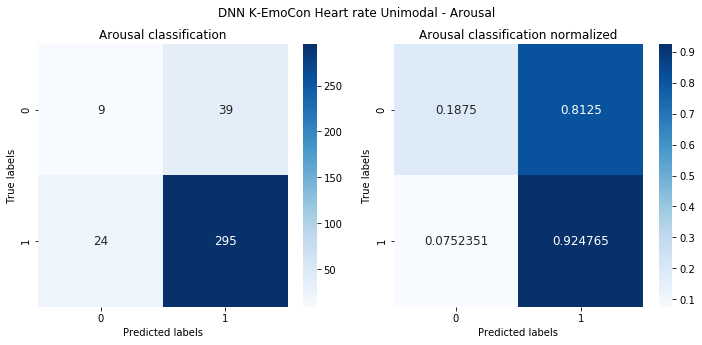

DNN validation score arousal with best hyperparameters -- Heart Rate Unimodal 0.5561324451410659


In [74]:
# Using the hyperparameters on validation set
# Change X_train variable names to avoid confusion later

X_train = hr_arousal_x
y_train = hr_arousal_y
X_test = hr_arousal_x_val
y_test = hr_arousal_y_val

# StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fitting DNN
hr_unimodal_arousal = Sequential()
hr_unimodal_arousal.add(Dense(96, input_dim=10, activation="relu"))
hr_unimodal_arousal.add(Dropout(0.5))
hr_unimodal_arousal.add(Dense(208, activation="relu"))
hr_unimodal_arousal.add(Dropout(0.0))
hr_unimodal_arousal.add(Dense(336, activation="relu"))
hr_unimodal_arousal.add(Dropout(0.4))
hr_unimodal_arousal.add(Dense(1, activation="sigmoid"))
opt = keras.optimizers.Adam(learning_rate=1e-05)
hr_unimodal_arousal.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
hr_unimodal_arousal.fit(X_train_scaled, y_train, epochs = 100, verbose=0)
hr_unimodal_arousal.save('KEmoCon_hr_latefusion_arousal.h5')
# Prediction
y_pred = hr_unimodal_arousal.predict(X_test_scaled, verbose=0)
y_pred = np.rint(y_pred)
uar = balanced_accuracy_score(y_test, y_pred)

# Plotting the confusion matrix
cm = confusion_matrix(y_test,y_pred)
cm_normalized = confusion_matrix(y_test,y_pred, normalize="true")
fig, axs = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('DNN K-EmoCon Heart rate Unimodal - Arousal')
sns.heatmap(cm, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[0]) 
sns.heatmap(cm_normalized, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[1]) 
axs[0].set_title('Arousal classification')
axs[1].set_title('Arousal classification normalized')
for ax in axs.flat:
    ax.set(xlabel='Predicted labels', ylabel='True labels')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
print("DNN validation score arousal with best hyperparameters -- Heart Rate Unimodal", uar)

## Late Fusion: Valence -- HR

In [29]:
hr_valence_x_all = hr_unimodal_labels_merge_valence.drop(columns=(["timestamp","Valence_binary","pid"]))
hr_valence_y_all = hr_unimodal_labels_merge_valence["Valence_binary"]

# Giving the same training and validation groups as in early fusion for valence audio lexical
train_idxs = sensor_merge_valence.loc[~sensor_merge_valence['pid'].isin([1, 17, 23])].index.to_list()
test_idxs = sensor_merge_valence.loc[sensor_merge_valence['pid'].isin([1, 17, 23])].index.to_list()

hr_valence_x = hr_valence_x_all.loc[train_idxs]
hr_valence_y = hr_valence_y_all.loc[train_idxs]
hr_valence_x_val = hr_valence_x_all.loc[test_idxs]
hr_valence_y_val = hr_valence_y_all.loc[test_idxs]

hr_train_test_groups_valence = hr_valence_groups.loc[train_idxs]
hr_val_groups_valence = hr_valence_groups.loc[test_idxs]

hr_train_test_groups_valence_unique = np.unique(hr_valence_groups.loc[train_idxs])
hr_val_groups_valence_unique = np.unique(hr_valence_groups.loc[test_idxs])
        
print(hr_valence_x.shape)
print(hr_valence_x_val.shape)
print("Train test groups: ", hr_train_test_groups_valence_unique)
print("Validation groups: ", hr_val_groups_valence_unique)

(2214, 10)
(387, 10)
Train test groups:  [ 4  5  8  9 10 12 13 14 15 18 20 22 26 27 28 30 31 32]
Validation groups:  [ 1 17 23]


In [88]:
# Hyperparameter tuning SVM

# StratifiedKGroupFold
sgkf = StratifiedGroupKFold(n_splits=10, random_state=10, shuffle=True)
svm = SVC()

# Grid search
space = dict()
space['degree'] = [2,3,4]
space['kernel'] = ['linear', 'poly', 'rbf', 'sigmoid']
space['C'] = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10]
space['class_weight'] = ['balanced',None]
search = GridSearchCV(svm, space, scoring='balanced_accuracy', verbose=4, n_jobs=-1, cv=sgkf)
result = search.fit(hr_valence_x, hr_valence_y, groups=hr_train_test_groups_valence)

# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)


Fitting 10 folds for each of 192 candidates, totalling 1920 fits
Best Score: 0.5601581533520986
Best Hyperparameters: {'C': 0.1, 'class_weight': 'balanced', 'degree': 2, 'kernel': 'rbf'}


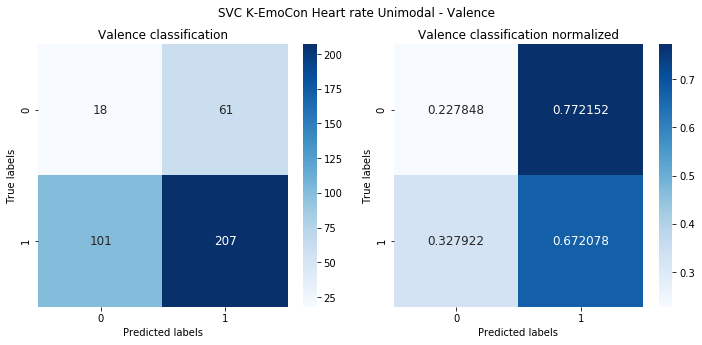

SVM validation Valence score with best hyperparameters - Heart rate Unimodal: 0.4499630116718724


In [37]:
# Using the hyperparameters on validation set
# Change X_train variable names to avoid confusion later

X_train = hr_valence_x
y_train = hr_valence_y
X_test = hr_valence_x_val
y_test = hr_valence_y_val

# StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fitting SVM training
svm = SVC(C=0.1,class_weight="balanced", degree=2, kernel="rbf")
svm.fit(X_train_scaled, y_train),
y_pred = svm.predict(X_test_scaled)

uar = balanced_accuracy_score(y_test,y_pred)

# Plotting the confusion matrix
cm = confusion_matrix(y_test,y_pred)
cm_normalized = confusion_matrix(y_test,y_pred, normalize="true")
fig, axs = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('SVC K-EmoCon Heart rate Unimodal - Valence')
sns.heatmap(cm, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[0]) 
sns.heatmap(cm_normalized, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[1]) 
axs[0].set_title('Valence classification')
axs[1].set_title('Valence classification normalized')
for ax in axs.flat:
    ax.set(xlabel='Predicted labels', ylabel='True labels')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("SVM validation Valence score with best hyperparameters - Heart rate Unimodal:", uar)

In [137]:
# Creating a train and test set for DNN hyperparameter tuning

cv = StratifiedGroupKFold(n_splits=5, random_state=12, shuffle=True)
for folds, (train_idxs, test_idxs) in enumerate(cv.split(hr_valence_x, hr_valence_y, train_test_groups_valence)):
    if folds == 1: 
        hr_valence_x_train = hr_valence_x_all.iloc[train_idxs]
        hr_valence_y_train = hr_valence_y_all.iloc[train_idxs]
        hr_valence_x_test = hr_valence_x_all.iloc[test_idxs]
        hr_valence_y_test = hr_valence_y_all.iloc[test_idxs]
        
        hr_valence_x_train_groups = np.unique(train_test_groups_valence.iloc[train_idxs])
        hr_valence_x_test_groups = np.unique(train_test_groups_valence.iloc[test_idxs])
        
print("Training groups: ", hr_valence_x_train_groups)
print("Testing groups: ", hr_valence_x_test_groups)

Training groups:  [ 4  5  8 12 13 14 15 18 20 22 27 28 30 32]
Testing groups:  [ 9 10 26 31]


In [92]:
# Hyperparameter tuning

def model_builder(hp):
    model = keras.Sequential()
    hp_units = hp.Int('units', min_value=16, max_value=512, step=16)
    model.add(Dense(hp_units, input_dim=10, activation="relu"))
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    
    dp1 = hp.Choice('dp1', values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
    model.add(Dropout(dp1))
    
    hp_units1 = hp.Int('units1', min_value=16, max_value=512, step=16)
    model.add(Dense(units=hp_units, activation='relu'))
    # Tune the number of units in the first Dense layer    
    dp2 = hp.Choice('dp2', values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
    model.add(Dropout(dp2))
    
    hp_units2 = hp.Int('units2', min_value=16, max_value=512, step=16)
    model.add(Dense(units=hp_units2, activation='relu'))
    
    dp3 = hp.Choice('dp3', values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
    model.add(Dropout(dp3))
    
    # Tune the learning rate for the optimizer    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss="binary_crossentropy",
                metrics=[UAR_metric])
    return model

# Initialize the hyperparameter tuner

tuner = kt.Hyperband(model_builder,objective=kt.Objective('val_UAR_metric', direction='max'),
                     max_epochs=100,
                     factor=10,
                     directory='KEmoCon_HR_Unimodal',
                     project_name='Trial1Valence')

# Stop early if validation doesn't change for 10 epochs
stop_early = keras.callbacks.EarlyStopping(monitor='val_UAR_metric', patience=10)
tuner.search(hr_valence_x_train, hr_valence_y_train, epochs=100, validation_data=(hr_valence_x_test, hr_valence_y_test), callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. \n First layer: {best_hps.get('units')} \n Second layer: {best_hps.get('units1')} \n Third layer: {best_hps.get('units2')} \n \n Dropout 1: {best_hps.get('dp1')} \n Dropout 2: {best_hps.get('dp2')} \n Dropout 3: {best_hps.get('dp3')} \n and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 131 Complete [00h 00m 02s]
val_UAR_metric: 0.5

Best val_UAR_metric So Far: 0.5247182250022888
Total elapsed time: 00h 03m 29s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. 
 First layer: 128 
 Second layer: 400 
 Third layer: 160 
 
 Dropout 1: 0.3 
 Dropout 2: 0.5 
 Dropout 3: 0.0 
 and the optimal learning rate for the optimizer
is 0.001.



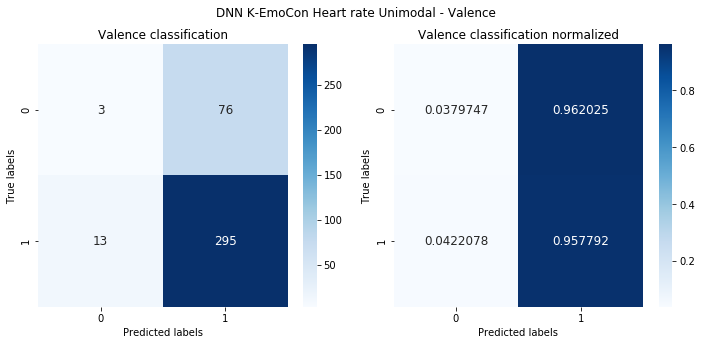

DNN validation score valence with best hyperparameters -- Heart Rate Unimodal 0.49788344566825576


In [34]:
# Using the hyperparameters on validation set
# Change X_train variable names to avoid confusion later

X_train = hr_valence_x
y_train = hr_valence_y
X_test = hr_valence_x_val
y_test = hr_valence_y_val

# StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fitting DNN
hr_unimodal_valence = Sequential()
hr_unimodal_valence.add(Dense(128, input_dim=10, activation="relu"))
hr_unimodal_valence.add(Dropout(0.3))
hr_unimodal_valence.add(Dense(400, activation="relu"))
hr_unimodal_valence.add(Dropout(0.5))
hr_unimodal_valence.add(Dense(160, activation="relu"))
hr_unimodal_valence.add(Dropout(0.0))
hr_unimodal_valence.add(Dense(1, activation="sigmoid"))
opt = keras.optimizers.Adam(learning_rate=0.001)
hr_unimodal_valence.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
hr_unimodal_valence.fit(X_train_scaled, y_train, epochs = 100, verbose=0)
hr_unimodal_valence.save('KEmoCon_hr_latefusion_valence.h5')

# Prediction
y_pred = hr_unimodal_valence.predict(X_test_scaled, verbose=0)
y_pred = np.rint(y_pred)
uar = balanced_accuracy_score(y_test, y_pred)

# Plotting the confusion matrix
cm = confusion_matrix(y_test,y_pred)
cm_normalized = confusion_matrix(y_test,y_pred, normalize="true")
fig, axs = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('DNN K-EmoCon Heart rate Unimodal - Valence')
sns.heatmap(cm, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[0]) 
sns.heatmap(cm_normalized, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[1]) 
axs[0].set_title('Valence classification')
axs[1].set_title('Valence classification normalized')
for ax in axs.flat:
    ax.set(xlabel='Predicted labels', ylabel='True labels')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
print("DNN validation score valence with best hyperparameters -- Heart Rate Unimodal", uar)

## Late Fusion: Arousal -- ACC

In [39]:
acc_arousal_x_all = acc_unimodal_labels_merge_arousal.drop(columns=(["timestamp","Arousal_binary","pid"]))
acc_arousal_y_all = acc_unimodal_labels_merge_arousal["Arousal_binary"]

# Giving the same training and validation groups as in early fusion for arousal audio lexical
train_idxs = sensor_merge_arousal.loc[~sensor_merge_arousal['pid'].isin([12, 18, 23])].index.to_list()
test_idxs = sensor_merge_arousal.loc[sensor_merge_arousal['pid'].isin([12, 18, 23])].index

acc_arousal_x = acc_arousal_x_all.loc[train_idxs]
acc_arousal_y = acc_arousal_y_all.loc[train_idxs]
acc_arousal_x_val = acc_arousal_x_all.loc[test_idxs]
acc_arousal_y_val = acc_arousal_y_all.loc[test_idxs]

acc_train_test_groups_arousal = acc_arousal_groups.loc[train_idxs]
acc_val_groups_arousal = acc_arousal_groups.loc[test_idxs]

acc_train_test_groups_arousal_unique = np.unique(acc_arousal_groups.loc[train_idxs])
acc_val_groups_arousal_unique = np.unique(acc_arousal_groups.loc[test_idxs])
        
print(acc_arousal_x.shape)
print(acc_arousal_x_val.shape)
print("Train test groups: ", acc_train_test_groups_arousal_unique)
print("Validation groups: ", acc_val_groups_arousal_unique)

(2592, 10)
(367, 10)
Train test groups:  [ 1  4  5  9 10 11 13 14 15 16 17 19 20 21 22 24 25 26 28 30 31]
Validation groups:  [12 18 23]


In [98]:
# Hyperparameter tuning

# StratifiedKGroupFold
sgkf = StratifiedGroupKFold(n_splits=10, random_state=10, shuffle=True)
svm = SVC()

# Grid search
space = dict()
space['degree'] = [2,3,4]
space['kernel'] = ['linear', 'poly', 'rbf', 'sigmoid']
space['C'] = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10]
space['class_weight'] = ['balanced',None]
search = GridSearchCV(svm, space, scoring='balanced_accuracy', verbose=4, n_jobs=-1, cv=sgkf)
result = search.fit(acc_arousal_x, acc_arousal_y, groups=acc_train_test_groups_arousal)

# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)


Fitting 10 folds for each of 192 candidates, totalling 1920 fits
Best Score: 0.545183069609372
Best Hyperparameters: {'C': 0.0001, 'class_weight': 'balanced', 'degree': 2, 'kernel': 'linear'}


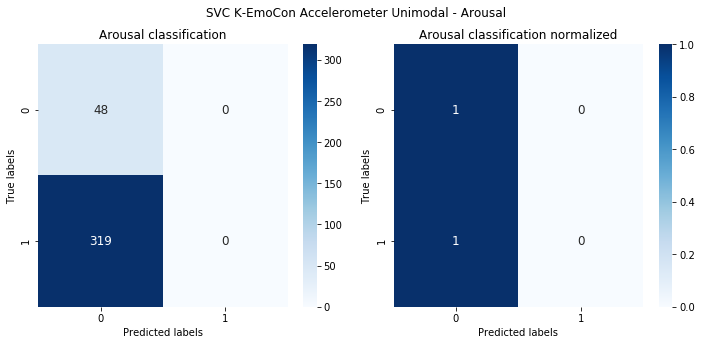

SVM validation Arousal score with best hyperparameters - Accelerometer Unimodal: 0.5


In [40]:
# Using the hyperparameters on validation set
# Change X_train variable names to avoid confusion later

X_train = acc_arousal_x
y_train = acc_arousal_y
X_test = acc_arousal_x_val
y_test = acc_arousal_y_val

# StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fitting SVM training
svm = SVC(C=0.0001,class_weight="balanced", degree=2, kernel="linear")
svm.fit(X_train_scaled, y_train),
y_pred = svm.predict(X_test_scaled)

uar = balanced_accuracy_score(y_test,y_pred)

# Plotting the confusion matrix
cm = confusion_matrix(y_test,y_pred)
cm_normalized = confusion_matrix(y_test,y_pred, normalize="true")
fig, axs = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('SVC K-EmoCon Accelerometer Unimodal - Arousal')
sns.heatmap(cm, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[0]) 
sns.heatmap(cm_normalized, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[1]) 
axs[0].set_title('Arousal classification')
axs[1].set_title('Arousal classification normalized')
for ax in axs.flat:
    ax.set(xlabel='Predicted labels', ylabel='True labels')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("SVM validation Arousal score with best hyperparameters - Accelerometer Unimodal:", uar)

In [141]:
# Creating a train and test set for DNN hyperparameter tuning

# Giving the same training and validation groups as in early fusion for arousal audio lexical
train_idxs = sensor_merge_arousal.loc[~sensor_merge_arousal['pid'].isin([4, 11, 31])].index.to_list()
test_idxs = sensor_merge_arousal.loc[sensor_merge_arousal['pid'].isin([4, 11, 31])].index.to_list()

acc_arousal_x_train = acc_arousal_x_all.loc[train_idxs]
acc_arousal_y_train = acc_arousal_y_all.loc[train_idxs]
acc_arousal_x_test = acc_arousal_x_all.loc[test_idxs]
acc_arousal_y_test = acc_arousal_y_all.loc[test_idxs]

acc_arousal_x_train_groups = np.unique(acc_arousal_groups.loc[train_idxs])
acc_arousal_x_test_groups = np.unique(acc_arousal_groups.loc[test_idxs])
        
print("Training groups: ", acc_arousal_x_train_groups)
print("Testing groups: ", acc_arousal_x_test_groups) # [ 4 11 31]

Training groups:  [ 1  5  9 10 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 28 30]
Testing groups:  [ 4 11 31]


In [102]:
# Hyperparameter tuning

def model_builder(hp):
    model = keras.Sequential()
    hp_units = hp.Int('units', min_value=16, max_value=512, step=16)
    model.add(Dense(hp_units, input_dim=10, activation="relu"))
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    
    dp1 = hp.Choice('dp1', values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
    model.add(Dropout(dp1))
    
    hp_units1 = hp.Int('units1', min_value=16, max_value=512, step=16)
    model.add(Dense(units=hp_units, activation='relu'))
    # Tune the number of units in the first Dense layer
    
    dp2 = hp.Choice('dp2', values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
    model.add(Dropout(dp2))
    
    hp_units2 = hp.Int('units2', min_value=16, max_value=512, step=16)
    model.add(Dense(units=hp_units2, activation='relu'))
    
    dp3 = hp.Choice('dp3', values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
    model.add(Dropout(dp3))
    
    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss="binary_crossentropy",
                metrics=[UAR_metric])
    return model

# Initialize the hyperparameter tuner

tuner = kt.Hyperband(model_builder,objective=kt.Objective('val_UAR_metric', direction='max'),
                     max_epochs=100,
                     factor=10,
                     directory='KEmoCon_ACC_Unimodal',
                     project_name='Trial2Arousal')

# Stop early if validation doesn't change for 10 epochs
stop_early = keras.callbacks.EarlyStopping(monitor='val_UAR_metric', patience=10)
tuner.search(acc_arousal_x_train, acc_arousal_y_train, epochs=100, validation_data=(acc_arousal_x_test, acc_arousal_y_test), callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. \n First layer: {best_hps.get('units')} \n Second layer: {best_hps.get('units1')} \n Third layer: {best_hps.get('units2')} \n \n Dropout 1: {best_hps.get('dp1')} \n Dropout 2: {best_hps.get('dp2')} \n Dropout 3: {best_hps.get('dp3')} \n and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 131 Complete [00h 00m 04s]
val_UAR_metric: 0.3333333432674408

Best val_UAR_metric So Far: 0.42297831177711487
Total elapsed time: 00h 03m 53s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. 
 First layer: 64 
 Second layer: 80 
 Third layer: 240 
 
 Dropout 1: 0.1 
 Dropout 2: 0.2 
 Dropout 3: 0.5 
 and the optimal learning rate for the optimizer
is 1e-05.



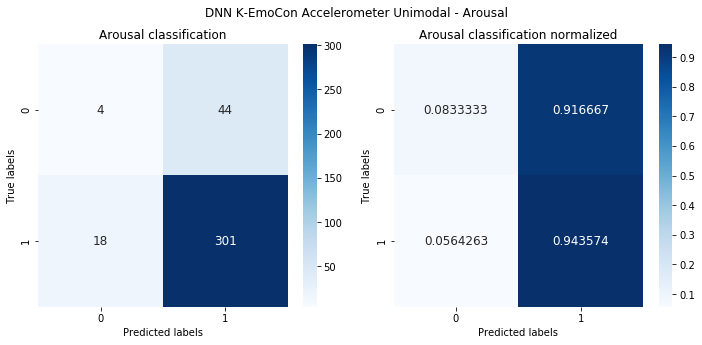

DNN validation score arousal with best hyperparameters -- Accelerometer Unimodal 0.5134535005224661


In [41]:
# Using the hyperparameters on validation set
# Change X_train variable names to avoid confusion later

X_train = acc_arousal_x
y_train = acc_arousal_y
X_test = acc_arousal_x_val
y_test = acc_arousal_y_val

# StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fitting DNN
acc_unimodal_arousal = Sequential()
acc_unimodal_arousal.add(Dense(64, input_dim=10, activation="relu"))
acc_unimodal_arousal.add(Dropout(0.1))
acc_unimodal_arousal.add(Dense(80, activation="relu"))
acc_unimodal_arousal.add(Dropout(0.2))
acc_unimodal_arousal.add(Dense(240, activation="relu"))
acc_unimodal_arousal.add(Dropout(0.5))
acc_unimodal_arousal.add(Dense(1, activation="sigmoid"))
opt = keras.optimizers.Adam(learning_rate=1e-05)
acc_unimodal_arousal.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
acc_unimodal_arousal.fit(X_train_scaled, y_train, epochs = 100, verbose=0)
acc_unimodal_arousal.save('KEmoCon_acc_latefusion_arousal.h5')
# Prediction
y_pred = acc_unimodal_arousal.predict(X_test_scaled, verbose=0)
y_pred = np.rint(y_pred)
uar = balanced_accuracy_score(y_test, y_pred)

# Plotting the confusion matrix
cm = confusion_matrix(y_test,y_pred)
cm_normalized = confusion_matrix(y_test,y_pred, normalize="true")
fig, axs = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('DNN K-EmoCon Accelerometer Unimodal - Arousal')
sns.heatmap(cm, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[0]) 
sns.heatmap(cm_normalized, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[1]) 
axs[0].set_title('Arousal classification')
axs[1].set_title('Arousal classification normalized')
for ax in axs.flat:
    ax.set(xlabel='Predicted labels', ylabel='True labels')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
print("DNN validation score arousal with best hyperparameters -- Accelerometer Unimodal", uar)

## Late Fusion: Valence -- ACC

In [43]:
acc_valence_x_all = acc_unimodal_labels_merge_valence.drop(columns=(["timestamp","Valence_binary","pid"]))
acc_valence_y_all = acc_unimodal_labels_merge_valence["Valence_binary"]

# Giving the same training and validation groups as in early fusion for valence audio lexical
train_idxs = sensor_merge_valence.loc[~sensor_merge_valence['pid'].isin([1,17,23])].index.to_list()
test_idxs = sensor_merge_valence.loc[sensor_merge_valence['pid'].isin([1,17,23])].index.to_list()

acc_valence_x = acc_valence_x_all.loc[train_idxs]
acc_valence_y = acc_valence_y_all.loc[train_idxs]
acc_valence_x_val = acc_valence_x_all.loc[test_idxs]
acc_valence_y_val = acc_valence_y_all.loc[test_idxs]

acc_train_test_groups_valence = acc_valence_groups.loc[train_idxs]
acc_val_groups_valence = acc_valence_groups.loc[test_idxs]

acc_train_test_groups_valence_unique = np.unique(acc_valence_groups.loc[train_idxs])
acc_val_groups_valence_unique = np.unique(acc_valence_groups.loc[test_idxs])
        
print(acc_valence_x.shape)
print(acc_valence_x_val.shape)
print("Train test groups: ", acc_train_test_groups_valence_unique)
print("Validation groups: ", acc_val_groups_valence_unique)

(2214, 10)
(387, 10)
Train test groups:  [ 4  5  8  9 10 12 13 14 15 18 20 22 26 27 28 30 31 32]
Validation groups:  [ 1 17 23]


In [146]:
# Hyperparameter tuning

# StratifiedKGroupFold
sgkf = StratifiedGroupKFold(n_splits=5, random_state=10, shuffle=True)
svm = SVC()

# Grid search
space = dict()
space['degree'] = [2,3,4]
space['kernel'] = ['linear', 'poly', 'rbf', 'sigmoid']
space['C'] = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10]
space['class_weight'] = ['balanced',None]
search = GridSearchCV(svm, space, scoring='balanced_accuracy', verbose=4, n_jobs=-1, cv=sgkf)
result = search.fit(acc_valence_x, acc_valence_y, groups=acc_train_test_groups_valence)

# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)


Fitting 5 folds for each of 192 candidates, totalling 960 fits
Best Score: 0.5187177415799098
Best Hyperparameters: {'C': 0.1, 'class_weight': 'balanced', 'degree': 2, 'kernel': 'rbf'}


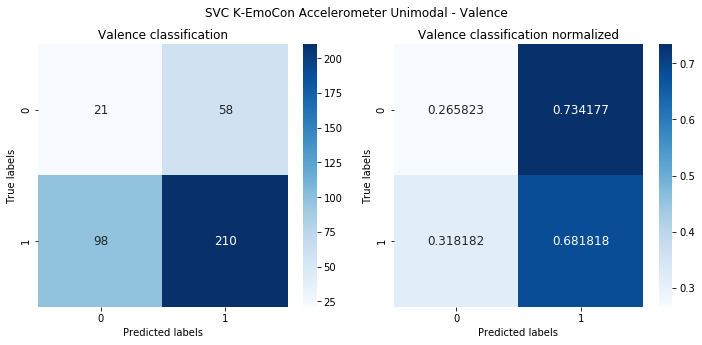

SVM validation Valence score with best hyperparameters - Accelerometer Unimodal: 0.47382048331415416


In [44]:
# Using the hyperparameters on validation set
# Change X_train variable names to avoid confusion later

X_train = acc_valence_x
y_train = acc_valence_y
X_test = acc_valence_x_val
y_test = acc_valence_y_val

# StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fitting SVM training
svm = SVC(C=0.1,class_weight='balanced', degree=2, kernel="rbf")
svm.fit(X_train_scaled, y_train),
y_pred = svm.predict(X_test_scaled)

uar = balanced_accuracy_score(y_test,y_pred)

# Plotting the confusion matrix
cm = confusion_matrix(y_test,y_pred)
cm_normalized = confusion_matrix(y_test,y_pred, normalize="true")
fig, axs = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('SVC K-EmoCon Accelerometer Unimodal - Valence')
sns.heatmap(cm, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[0]) 
sns.heatmap(cm_normalized, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[1]) 
axs[0].set_title('Valence classification')
axs[1].set_title('Valence classification normalized')
for ax in axs.flat:
    ax.set(xlabel='Predicted labels', ylabel='True labels')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("SVM validation Valence score with best hyperparameters - Accelerometer Unimodal:", uar)

In [51]:
# Creating a train and test set for DNN hyperparameter tuning

cv = StratifiedGroupKFold(n_splits=5, random_state=12, shuffle=True)
for folds, (train_idxs, test_idxs) in enumerate(cv.split(acc_valence_x, acc_valence_y, train_test_groups_valence)):
    if folds == 1: 
        acc_valence_x_train = acc_valence_x_all.iloc[train_idxs]
        acc_valence_y_train = acc_valence_y_all.iloc[train_idxs]
        acc_valence_x_test = acc_valence_x_all.iloc[test_idxs]
        acc_valence_y_test = acc_valence_y_all.iloc[test_idxs]
        
        acc_valence_x_train_groups = np.unique(train_test_groups_valence.iloc[train_idxs])
        acc_valence_x_test_groups = np.unique(train_test_groups_valence.iloc[test_idxs])
        
print("Training groups: ", acc_valence_x_train_groups)
print("Testing groups: ", acc_valence_x_test_groups) # 4, 28, 30

Training groups:  [ 5  8  9 10 12 13 14 15 18 20 22 26 27 31 32]
Testing groups:  [ 4 28 30]


In [107]:
# Hyperparameter tuning

def model_builder(hp):
    model = keras.Sequential()
    hp_units = hp.Int('units', min_value=16, max_value=512, step=16)
    model.add(Dense(hp_units, input_dim=10, activation="relu"))
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    
    dp1 = hp.Choice('dp1', values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
    model.add(Dropout(dp1))
    
    hp_units1 = hp.Int('units1', min_value=16, max_value=512, step=16)
    model.add(Dense(units=hp_units, activation='relu'))
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    
    dp2 = hp.Choice('dp2', values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
    model.add(Dropout(dp2))
    
    hp_units2 = hp.Int('units2', min_value=16, max_value=512, step=16)
    model.add(Dense(units=hp_units2, activation='relu'))
    
    dp3 = hp.Choice('dp3', values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
    model.add(Dropout(dp3))
    
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss="binary_crossentropy",
                metrics=[UAR_metric])
    return model

# Initialize the hyperparameter tuner

tuner = kt.Hyperband(model_builder,objective=kt.Objective('val_UAR_metric', direction='max'),
                     max_epochs=100,
                     factor=10,
                     directory='KEmoCon_ACC_Unimodal',
                     project_name='Trial2Valence')

# Stop early if validation doesn't change for 10 epochs
stop_early = keras.callbacks.EarlyStopping(monitor='val_UAR_metric', patience=10)
tuner.search(acc_valence_x_train, acc_valence_y_train, epochs=100, validation_data=(acc_valence_x_test, acc_valence_y_test), callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. \n First layer: {best_hps.get('units')} \n Second layer: {best_hps.get('units1')} \n Third layer: {best_hps.get('units2')} \n \n Dropout 1: {best_hps.get('dp1')} \n Dropout 2: {best_hps.get('dp2')} \n Dropout 3: {best_hps.get('dp3')} \n and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 131 Complete [00h 00m 03s]
val_UAR_metric: 0.5

Best val_UAR_metric So Far: 0.5272177457809448
Total elapsed time: 00h 03m 40s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. 
 First layer: 448 
 Second layer: 352 
 Third layer: 512 
 
 Dropout 1: 0.4 
 Dropout 2: 0.2 
 Dropout 3: 0.2 
 and the optimal learning rate for the optimizer
is 0.001.



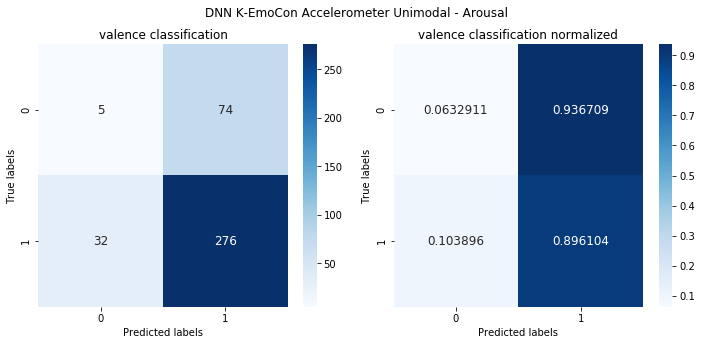

DNN validation score valence with best hyperparameters -- Accelerometer Unimodal 0.4796975176722012


In [46]:
# Using the hyperparameters on validation set
# Change X_train variable names to avoid confusion later

X_train = acc_valence_x
y_train = acc_valence_y
X_test = acc_valence_x_val
y_test = acc_valence_y_val

# StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fitting DNN
acc_unimodal_valence = Sequential()
acc_unimodal_valence.add(Dense(448, input_dim=10, activation="relu"))
acc_unimodal_valence.add(Dropout(0.4))
acc_unimodal_valence.add(Dense(352, activation="relu"))
acc_unimodal_valence.add(Dropout(0.2))
acc_unimodal_valence.add(Dense(512, activation="relu"))
acc_unimodal_valence.add(Dropout(0.2))
acc_unimodal_valence.add(Dense(1, activation="sigmoid"))
opt = keras.optimizers.Adam(learning_rate=0.001)
acc_unimodal_valence.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
acc_unimodal_valence.fit(X_train_scaled, y_train, epochs = 100, verbose=0)
acc_unimodal_valence.save('KEmoCon_acc_latefusion_valence.h5')
# Prediction
y_pred = acc_unimodal_valence.predict(X_test_scaled, verbose=0)
y_pred = np.rint(y_pred)
uar = balanced_accuracy_score(y_test, y_pred)

# Plotting the confusion matrix
cm = confusion_matrix(y_test,y_pred)
cm_normalized = confusion_matrix(y_test,y_pred, normalize="true")
fig, axs = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('DNN K-EmoCon Accelerometer Unimodal - Arousal')
sns.heatmap(cm, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[0]) 
sns.heatmap(cm_normalized, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[1]) 
axs[0].set_title('valence classification')
axs[1].set_title('valence classification normalized')
for ax in axs.flat:
    ax.set(xlabel='Predicted labels', ylabel='True labels')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
print("DNN validation score valence with best hyperparameters -- Accelerometer Unimodal", uar)

## Late fusion (HR and ACC) - Arousal

Late fusion averaging 0.5187108150470219
Late fusion averaging prediction after converting predictions to binary 0.5497648902821317
Late fusion max of either input 0.519265935214211
Late fusion median 0.5187108150470219


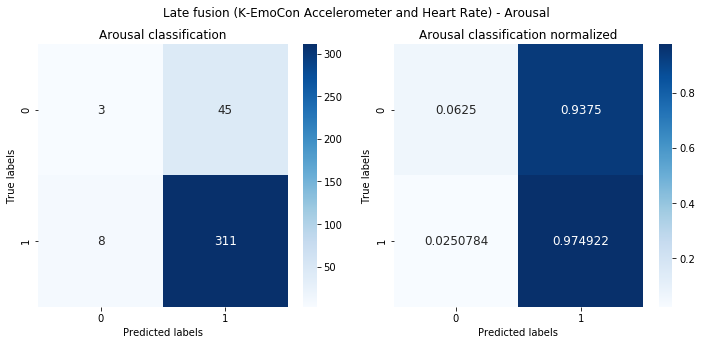

In [47]:
# Late fusion using averaging of predictions

# Find true values of arousal in validation set [001, 006, 010] that is common for both

if (hr_arousal_y_val.equals(acc_arousal_y_val)):
    hr_acc_y_val = acc_arousal_y_val # Should be the same as hr
else:
    raise("labels are not same")
    
# Get best DNN models and average predictions

# StandardScaler hr
scaler_hr = StandardScaler()
hr_arousal_x_scaled = scaler_hr.fit_transform(hr_arousal_x) # train
hr_arousal_x_val_scaled = scaler_hr.transform(hr_arousal_x_val) #test 

# Best DNN for hr arousal
hr_unimodal_arousal = Sequential()
hr_unimodal_arousal.add(Dense(96, input_dim=10, activation="relu"))
hr_unimodal_arousal.add(Dropout(0.5))
hr_unimodal_arousal.add(Dense(208, activation="relu"))
hr_unimodal_arousal.add(Dropout(0.0))
hr_unimodal_arousal.add(Dense(336, activation="relu"))
hr_unimodal_arousal.add(Dropout(0.4))
hr_unimodal_arousal.add(Dense(1, activation="sigmoid"))
opt = keras.optimizers.Adam(learning_rate=1e-05)
hr_unimodal_arousal.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
hr_unimodal_arousal.fit(hr_arousal_x_scaled, hr_arousal_y, epochs = 100, verbose=0)
# Prediction
hr_unimodal_arousal_y_pred = hr_unimodal_arousal.predict(hr_arousal_x_val_scaled, verbose=0)

# Best DNN for acc arousal

# StandardScaler acc
scaler_acc = StandardScaler()
acc_arousal_x_scaled = scaler_acc.fit_transform(acc_arousal_x) # train
acc_arousal_x_val_scaled = scaler_acc.transform(acc_arousal_x_val) #test 

acc_unimodal_arousal = Sequential()
acc_unimodal_arousal.add(Dense(64, input_dim=10, activation="relu"))
acc_unimodal_arousal.add(Dropout(0.1))
acc_unimodal_arousal.add(Dense(80, activation="relu"))
acc_unimodal_arousal.add(Dropout(0.2))
acc_unimodal_arousal.add(Dense(240, activation="relu"))
acc_unimodal_arousal.add(Dropout(0.5))
acc_unimodal_arousal.add(Dense(1, activation="sigmoid"))
opt = keras.optimizers.Adam(learning_rate=1e-05)
acc_unimodal_arousal.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
acc_unimodal_arousal.fit(acc_arousal_x_scaled, acc_arousal_y, epochs = 100, verbose=0)
# Prediction
acc_unimodal_arousal_y_pred = acc_unimodal_arousal.predict(acc_arousal_x_val_scaled, verbose=0)

# Evaluate on 
hr_acc_pred_merge_arousal = np.array([hr_unimodal_arousal_y_pred,acc_unimodal_arousal_y_pred])

# Averaging prediction (baseline)
late_fusion_hr_acc_pred_avg = np.rint(hr_acc_pred_merge_arousal.mean(axis=0))
uar_late_fusion_hr_acc_pred_avg = balanced_accuracy_score(hr_arousal_y_val, late_fusion_hr_acc_pred_avg)
print("Late fusion averaging", uar_late_fusion_hr_acc_pred_avg)

# Averaging prediction after converting predictions (baseline)
hr_acc_pred_merge_arousal_binary = np.array([np.rint(hr_unimodal_arousal_y_pred),np.rint(acc_unimodal_arousal_y_pred)])
late_fusion_hr_acc_pred_avg_binary = np.rint(hr_acc_pred_merge_arousal_binary.mean(axis=0))
uar_late_fusion_hr_acc_pred_binary= balanced_accuracy_score(hr_arousal_y_val, late_fusion_hr_acc_pred_avg_binary)
print("Late fusion averaging prediction after converting predictions to binary",uar_late_fusion_hr_acc_pred_binary)

# Taking max prediction
late_fusion_hr_acc_pred_max = np.rint(hr_acc_pred_merge_arousal.max(axis=0))
uar_late_fusion_hr_acc_pred_max = balanced_accuracy_score(hr_arousal_y_val, late_fusion_hr_acc_pred_max)
print("Late fusion max of either input", uar_late_fusion_hr_acc_pred_max)

# Taking median
late_fusion_hr_acc_pred_median = np.rint(np.median(hr_acc_pred_merge_arousal, axis=0))
uar_late_fusion_hr_acc_pred_median = balanced_accuracy_score(hr_arousal_y_val, late_fusion_hr_acc_pred_median)
print("Late fusion median", uar_late_fusion_hr_acc_pred_median)


cm = confusion_matrix(hr_arousal_y_val,late_fusion_hr_acc_pred_avg)
cm_normalized = confusion_matrix(hr_arousal_y_val,late_fusion_hr_acc_pred_avg, normalize="true")
fig, axs = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('Late fusion (K-EmoCon Accelerometer and Heart Rate) - Arousal')
sns.heatmap(cm, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[0]) 
sns.heatmap(cm_normalized, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[1]) 
axs[0].set_title('Arousal classification')
axs[1].set_title('Arousal classification normalized')
for ax in axs.flat:
    ax.set(xlabel='Predicted labels', ylabel='True labels')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Late fusion averaging 0.4897665625513727
Late fusion averaging prediction after converting predictions to binary 0.4712518494164064
Late fusion max of either input 0.5030823606772974
Late fusion median 0.4897665625513727


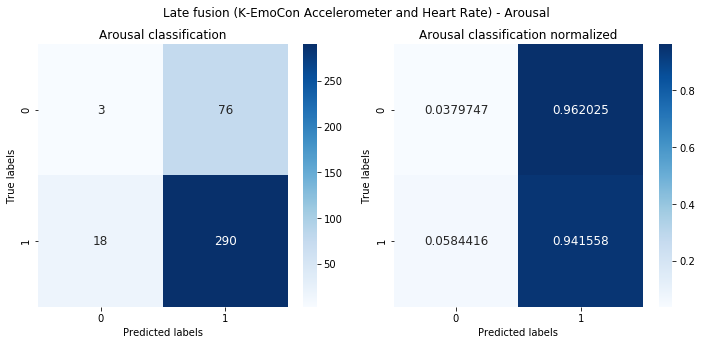

In [48]:
# Late fusion using averaging of predictions

# Find true values of valence in validation set [001, 006, 010] that is common for both

if (hr_valence_y_val.equals(acc_valence_y_val)):
    hr_acc_y_val = acc_valence_y_val # Should be the same as hr
else:
    raise("labels are not same")
    
# Get best DNN models and average predictions

# StandardScaler hr
scaler_hr = StandardScaler()
hr_valence_x_scaled = scaler_hr.fit_transform(hr_valence_x) # train
hr_valence_x_val_scaled = scaler_hr.transform(hr_valence_x_val) #test 

# Best DNN for hr valence
hr_unimodal_valence = Sequential()
hr_unimodal_valence.add(Dense(128, input_dim=10, activation="relu"))
hr_unimodal_valence.add(Dropout(0.3))
hr_unimodal_valence.add(Dense(400, activation="relu"))
hr_unimodal_valence.add(Dropout(0.5))
hr_unimodal_valence.add(Dense(160, activation="relu"))
hr_unimodal_valence.add(Dropout(0.0))
hr_unimodal_valence.add(Dense(1, activation="sigmoid"))
opt = keras.optimizers.Adam(learning_rate=0.001)
hr_unimodal_valence.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
hr_unimodal_valence.fit(hr_valence_x_scaled, hr_valence_y, epochs = 100, verbose=0)
# Prediction
hr_unimodal_valence_y_pred = hr_unimodal_valence.predict(hr_valence_x_val_scaled, verbose=0)

# Best DNN for acc valence

# StandardScaler acc
scaler_acc = StandardScaler()
acc_valence_x_scaled = scaler_acc.fit_transform(acc_valence_x) # train
acc_valence_x_val_scaled = scaler_acc.transform(acc_valence_x_val) #test 

acc_unimodal_valence = Sequential()
acc_unimodal_valence.add(Dense(448, input_dim=10, activation="relu"))
acc_unimodal_valence.add(Dropout(0.4))
acc_unimodal_valence.add(Dense(352, activation="relu"))
acc_unimodal_valence.add(Dropout(0.2))
acc_unimodal_valence.add(Dense(512, activation="relu"))
acc_unimodal_valence.add(Dropout(0.2))
acc_unimodal_valence.add(Dense(1, activation="sigmoid"))
opt = keras.optimizers.Adam(learning_rate=0.001)
acc_unimodal_valence.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
acc_unimodal_valence.fit(acc_valence_x_scaled, acc_valence_y, epochs = 100, verbose=0)
# Prediction
acc_unimodal_valence_y_pred = acc_unimodal_valence.predict(acc_valence_x_val_scaled, verbose=0)

# Evaluate on 
hr_acc_pred_merge_valence = np.array([hr_unimodal_valence_y_pred,acc_unimodal_valence_y_pred])

# Averaging prediction (baseline)
late_fusion_hr_acc_pred_avg = np.rint(hr_acc_pred_merge_valence.mean(axis=0))
uar_late_fusion_hr_acc_pred_avg = balanced_accuracy_score(hr_valence_y_val, late_fusion_hr_acc_pred_avg)
print("Late fusion averaging", uar_late_fusion_hr_acc_pred_avg)

# Averaging prediction after converting predictions (baseline)
hr_acc_pred_merge_valence_binary = np.array([np.rint(hr_unimodal_valence_y_pred),np.rint(acc_unimodal_valence_y_pred)])
late_fusion_hr_acc_pred_avg_binary = np.rint(hr_acc_pred_merge_valence_binary.mean(axis=0))
uar_late_fusion_hr_acc_pred_binary= balanced_accuracy_score(hr_valence_y_val, late_fusion_hr_acc_pred_avg_binary)
print("Late fusion averaging prediction after converting predictions to binary",uar_late_fusion_hr_acc_pred_binary)

# Taking max prediction
late_fusion_hr_acc_pred_max = np.rint(hr_acc_pred_merge_valence.max(axis=0))
uar_late_fusion_hr_acc_pred_max = balanced_accuracy_score(hr_valence_y_val, late_fusion_hr_acc_pred_max)
print("Late fusion max of either input", uar_late_fusion_hr_acc_pred_max)

# Taking median
late_fusion_hr_acc_pred_median = np.rint(np.median(hr_acc_pred_merge_valence, axis=0))
uar_late_fusion_hr_acc_pred_median = balanced_accuracy_score(hr_valence_y_val, late_fusion_hr_acc_pred_median)
print("Late fusion median", uar_late_fusion_hr_acc_pred_median)


cm = confusion_matrix(hr_valence_y_val,late_fusion_hr_acc_pred_avg)
cm_normalized = confusion_matrix(hr_valence_y_val,late_fusion_hr_acc_pred_avg, normalize="true")
fig, axs = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('Late fusion (K-EmoCon Accelerometer and Heart Rate) - Valence')
sns.heatmap(cm, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[0]) 
sns.heatmap(cm_normalized, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[1]) 
axs[0].set_title('Valence classification')
axs[1].set_title('Valence classification normalized')
for ax in axs.flat:
    ax.set(xlabel='Predicted labels', ylabel='True labels')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [30]:
# Unimodal hr arousal
balanced_accuracy_score(hr_arousal_y_val,np.rint(hr_unimodal_arousal_y_pred))

0.5